In [2]:
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
import matplotlib.pyplot as plt
import numpy as np
from skimage.feature import hog
import pandas as pd
from sklearn.feature_selection import VarianceThreshold, SelectPercentile, f_classif
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay
import numpy as np
from sklearn.metrics import precision_score

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()


x_train = x_train / 255.0
x_test = x_test / 255.0

x_train = x_train[..., np.newaxis]
x_test = x_test[..., np.newaxis]

print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")

x_train shape: (60000, 28, 28, 1), y_train shape: (60000,)


In [3]:
x_train_flat = x_train.reshape(x_train.shape[0], -1)
x_test_flat = x_test.reshape(x_test.shape[0], -1)

pca = PCA(n_components=20)
x_train_pca = pca.fit_transform(x_train_flat)
x_test_pca = pca.transform(x_test_flat)

In [4]:
def apply_hog_fixed(images):
    hog_features = []
    for img in images:
        feature, _= hog(img, orientations=9, pixels_per_cell=(8, 8),
                         cells_per_block=(2, 2), visualize=True, channel_axis=2)
        hog_features.append(feature)
    return np.array(hog_features)

hog_features_train = apply_hog_fixed(x_train)
hog_features_test = apply_hog_fixed(x_test)

print(f"HOG Features Train Shape: {hog_features_train.shape}")
print(f"HOG Features Test Shape: {hog_features_test.shape}")

HOG Features Train Shape: (60000, 144)
HOG Features Test Shape: (10000, 144)


## 3.1

In [5]:
scaler = StandardScaler()

scaler.fit(x_train_pca)

x_train_pca_standardized = scaler.transform(x_train_pca)

x_test_pca_standardized = scaler.transform(x_test_pca)


scaler_hog = StandardScaler()
x_train_hog_standardized = scaler_hog.fit_transform(hog_features_train)
x_test_hog_standardized = scaler_hog.transform(hog_features_test)

x_train_combined = np.hstack((x_train_pca_standardized, x_train_hog_standardized))
x_test_combined = np.hstack((x_test_pca_standardized, x_test_hog_standardized))

# variance_threshold = VarianceThreshold(threshold=1)
# x_train_variance = variance_threshold.fit_transform(x_train_combined)
# x_test_variance = variance_threshold.transform(x_test_combined)

# print("Dimensiuni înainte și după Variance Threshold:")
# print(f"Dimensiuni train înainte: {x_train_combined.shape}, după: {x_train_variance.shape}")
# print(f"Dimensiuni test înainte: {x_test_combined.shape}, după: {x_test_variance.shape}")


select_percentile = SelectPercentile(f_classif, percentile=35)
x_train_final = select_percentile.fit_transform(x_train_combined, y_train)
x_test_final = select_percentile.transform(x_test_combined)

print(f"Dimensiuni finale: Train: {x_train_final.shape}, Test: {x_test_final.shape}")



Dimensiuni finale: Train: (60000, 58), Test: (10000, 58)


In [6]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

# Transformă datele în tensori PyTorch
x_train_tensor = torch.tensor(x_train_final, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test_final, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Creează DataLoader pentru train și test
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)



C:\Users\raduf\AppData\Roaming\Python\Python37\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
import torch.nn as nn

# class MLP(nn.Module):
#     def __init__(self, input_size, hidden_sizes, output_size):
#         super(MLP, self).__init__()
#         self.fc1 = nn.Linear(input_size, hidden_sizes[0])
#         self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
#         self.fc3 = nn.Linear(hidden_sizes[1], output_size)
#         self.relu = nn.ReLU()
#         # self.dropout = nn.Dropout(0.2)

#     def forward(self, x):
#         x = self.relu(self.fc1(x))
#         # x = self.dropout(x)
#         x = self.relu(self.fc2(x))
#         # x = self.dropout(x)
#         x = self.fc3(x)
#         return x

class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_sizes[0], output_size)
        
    def forward(self, x):
        z = self.fc1(x)
        z = self.relu(z)
        z = self.fc2(z)
        return z

# Creează modelul
input_size = x_train_final.shape[1]  # Dimensiunea caracteristicilor
hidden_sizes = [128, 64]
output_size = 10  # 10 clase pentru Fashion-MNIST

model = MLP(input_size, hidden_sizes, output_size)



In [8]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 20
train_losses, test_losses, train_accuracies, test_accuracies = [], [], [], []

for epoch in range(num_epochs):
    # Antrenare
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(correct / total)

    # Testare
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    test_losses.append(running_loss / len(test_loader))
    test_accuracies.append(correct / total)

    print(f"Epoch {epoch+1}/{num_epochs},\n Train Loss: {train_losses[-1]:.4f},\n Test Loss: {test_losses[-1]:.4f}, "
          f"\nTrain Acc: {train_accuracies[-1]:.4f},\n Test Acc: {test_accuracies[-1]:.4f}")


Epoch 1/20,
 Train Loss: 0.6836,
 Test Loss: 0.5554, 
Train Acc: 0.7474,
 Test Acc: 0.7888
Epoch 2/20,
 Train Loss: 0.5139,
 Test Loss: 0.5110, 
Train Acc: 0.8015,
 Test Acc: 0.8056
Epoch 3/20,
 Train Loss: 0.4794,
 Test Loss: 0.4898, 
Train Acc: 0.8179,
 Test Acc: 0.8126
Epoch 4/20,
 Train Loss: 0.4588,
 Test Loss: 0.4760, 
Train Acc: 0.8241,
 Test Acc: 0.8193
Epoch 5/20,
 Train Loss: 0.4428,
 Test Loss: 0.4749, 
Train Acc: 0.8317,
 Test Acc: 0.8200
Epoch 6/20,
 Train Loss: 0.4320,
 Test Loss: 0.4662, 
Train Acc: 0.8355,
 Test Acc: 0.8242
Epoch 7/20,
 Train Loss: 0.4229,
 Test Loss: 0.4656, 
Train Acc: 0.8386,
 Test Acc: 0.8237
Epoch 8/20,
 Train Loss: 0.4149,
 Test Loss: 0.4633, 
Train Acc: 0.8417,
 Test Acc: 0.8227
Epoch 9/20,
 Train Loss: 0.4091,
 Test Loss: 0.4541, 
Train Acc: 0.8438,
 Test Acc: 0.8269
Epoch 10/20,
 Train Loss: 0.4034,
 Test Loss: 0.4509, 
Train Acc: 0.8462,
 Test Acc: 0.8282
Epoch 11/20,
 Train Loss: 0.3999,
 Test Loss: 0.4452, 
Train Acc: 0.8465,
 Test Acc: 0.82

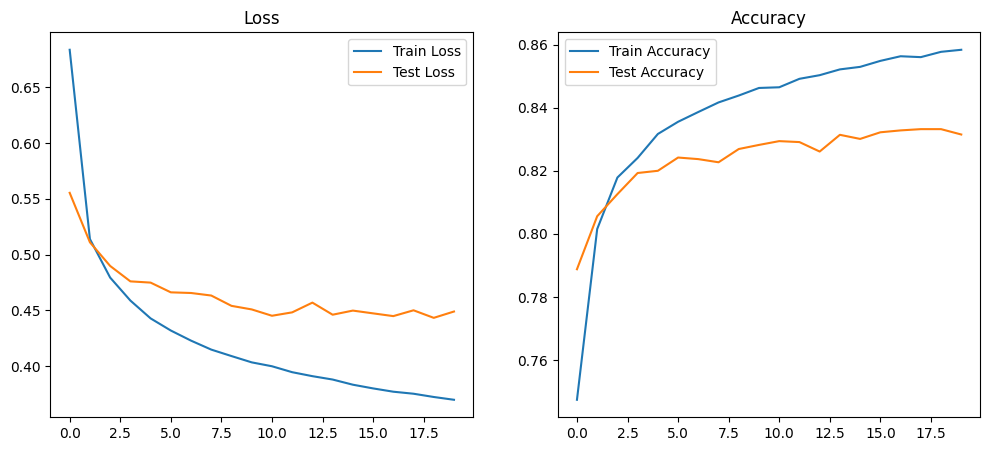

In [10]:
import matplotlib.pyplot as plt

# Curbele de pierdere
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss')
plt.legend()

# Curbele de acuratețe
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Accuracy')
plt.legend()

plt.show()


In [11]:
# from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# # Preziceri pe setul de test
# model.eval()
# all_preds = []
# all_labels = []

# with torch.no_grad():
#     for inputs, labels in test_loader:
#         inputs, labels = inputs.to(device), labels.to(device)
#         outputs = model(inputs)
#         _, predicted = torch.max(outputs, 1)
#         all_preds.extend(predicted.cpu().numpy())
#         all_labels.extend(labels.cpu().numpy())

# print(classification_report(all_labels, all_preds))
# ConfusionMatrixDisplay.from_predictions(all_labels, all_preds, cmap='Blues')
# plt.show()


## 3.2

In [12]:
# x_train_flat = x_train.reshape(x_train.shape[0], -1)
# x_test_flat = x_test.reshape(x_test.shape[0], -1)

# # Normalizează datele
# x_train_flat = x_train_flat / 255.0
# x_test_flat = x_test_flat / 255.0

# print(f"Dimensiuni după liniarizare: Train: {x_train_flat.shape}, Test: {x_test_flat.shape}")


In [13]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout

# model = Sequential([
#     Dense(256, activation='relu', input_shape=(784,)),  # 784 = 28x28
#     Dropout(0.2),
#     Dense(128, activation='relu'),
#     Dropout(0.2),
#     Dense(10, activation='softmax')  # 10 clase
# ])

# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [14]:
# history = model.fit(x_train_flat, y_train, validation_data=(x_test_flat, y_test), epochs=20, batch_size=64)


In [15]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(12, 5))
# plt.subplot(1, 2, 1)
# plt.plot(history.history['loss'], label='Train Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.title('Loss')
# plt.legend()

# plt.subplot(1, 2, 2)
# plt.plot(history.history['accuracy'], label='Train Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
# plt.title('Accuracy')
# plt.legend()
# plt.show()


In [16]:
# from sklearn.metrics import classification_report, ConfusionMatrixDisplay
# import numpy as np

# # Preziceri pe datele de test
# y_pred = np.argmax(model.predict(x_test_flat), axis=1)

# # Raport și matrice de confuzie
# print(classification_report(y_test, y_pred))

# ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')
# plt.show()


## 3.3

## 3.4

In [17]:
# from tensorflow.image import resize
# import numpy as np

# # Transformă imaginile grayscale în RGB
# x_train_rgb = np.repeat(x_train, 3, axis=-1)
# x_test_rgb = np.repeat(x_test, 3, axis=-1)

# # Rescalează imaginile la dimensiunea 32x32
# x_train_resized = np.array([resize(img, (32, 32)).numpy() for img in x_train_rgb])
# x_test_resized = np.array([resize(img, (32, 32)).numpy() for img in x_test_rgb])

# print(f"Dimensiuni imagini după transformare: {x_train_resized.shape}, {x_test_resized.shape}")


In [18]:
# from tensorflow.keras.applications import ResNet50
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# # Încarcă modelul ResNet-18 pre-antrenat
# base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# # Blochează straturile pre-antrenate
# for layer in base_model.layers:
#     layer.trainable = False

# # Adaugă straturi personalizate pentru clasificare
# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# x = Dense(128, activation='relu')(x)
# predictions = Dense(10, activation='softmax')(x)

# model = Model(inputs=base_model.input, outputs=predictions)


In [19]:
# from tensorflow.keras.optimizers import SGD

# model.compile(optimizer=SGD(learning_rate=0.001, momentum=0.9),
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])

# history = model.fit(x_train_resized, y_train, validation_data=(x_test_resized, y_test), epochs=20, batch_size=64)


In [20]:
# for layer in base_model.layers:
#     layer.trainable = True

# # Recompilează modelul cu o rată de învățare mai mică
# model.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9),
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])

# history_finetune = model.fit(x_train_resized, y_train, validation_data=(x_test_resized, y_test), epochs=10, batch_size=64)


In [21]:
# # Afișează graficele
# import matplotlib.pyplot as plt

# plt.figure(figsize=(12, 5))
# plt.subplot(1, 2, 1)
# plt.plot(history.history['loss'], label='Train Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.title('Loss')
# plt.legend()

# plt.subplot(1, 2, 2)
# plt.plot(history.history['accuracy'], label='Train Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
# plt.title('Accuracy')
# plt.legend()
# plt.show()
